<a href="https://colab.research.google.com/github/saxonmahar/Deeplearning/blob/main/VAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
batch_size = 128
learning_rate = 1e-3
latent_dim = 20
epochs = 30

In [11]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(400, latent_dim)  # Log-variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # z = μ + σ * ε

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # KL Divergence: KL(N(μ,σ²) || N(0,1))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [14]:
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch [1/30] Loss: 164.2327
Epoch [2/30] Loss: 121.2700
Epoch [3/30] Loss: 114.6335
Epoch [4/30] Loss: 111.8005
Epoch [5/30] Loss: 110.0131
Epoch [6/30] Loss: 108.8657
Epoch [7/30] Loss: 108.0105
Epoch [8/30] Loss: 107.4004
Epoch [9/30] Loss: 106.8901
Epoch [10/30] Loss: 106.4908
Epoch [11/30] Loss: 106.1175
Epoch [12/30] Loss: 105.7735
Epoch [13/30] Loss: 105.4848
Epoch [14/30] Loss: 105.2961
Epoch [15/30] Loss: 105.0509
Epoch [16/30] Loss: 104.8847
Epoch [17/30] Loss: 104.6655
Epoch [18/30] Loss: 104.5005
Epoch [19/30] Loss: 104.4217
Epoch [20/30] Loss: 104.1836
Epoch [21/30] Loss: 104.1086
Epoch [22/30] Loss: 104.0040
Epoch [23/30] Loss: 103.7998
Epoch [24/30] Loss: 103.7195
Epoch [25/30] Loss: 103.5718
Epoch [26/30] Loss: 103.5095
Epoch [27/30] Loss: 103.4243
Epoch [28/30] Loss: 103.2981
Epoch [29/30] Loss: 103.2328
Epoch [30/30] Loss: 103.1451


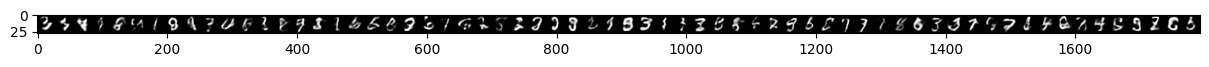

In [15]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    sample = model.decode(z).cpu()
    sample = sample.view(64, 1, 28, 28)

    # Show generated images
    grid = torch.cat([sample[i] for i in range(64)], dim=2)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.squeeze().numpy(), cmap='gray')
    plt.show()